# COMP47670 Assignment II Autumn 2023
## Time Series Running Data

## Objective
The objective of this assignment is to identify good models for classifying time series data.  
The data is from an accelerometer sensor and there are samples of fatigued and non-fatigued running. The data has been segmented into strides and the segments (samples) are labelled F (fatigued) and NF (not fatigued). The data for two subjects A and B are available in the files  `fatigueA.csv` and  `fatigueB.csv`. This dataset is extracted from a much larger dataset described [here](https://openreview.net/pdf?id=9c0lAonDNP).  
At present, the best performing method for time-series classification is [Rocket](https://openreview.net/pdf?id=9c0lAonDNP). 
A rocket implementation is available in the [sktime tool kit](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html). This sktime implementation can be used in this assignment.   
Some code to get you started in available in the notebook `RunningCore`.



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sktime.transformations.panel.rocket import Rocket
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
import warnings

warnings.filterwarnings("ignore")

In [3]:
fatigue_df = pd.read_csv('fatigueA.csv', header = None) # sep = '\s+')
print(fatigue_df.shape)
fatigue_df.head(5)

(421, 181)


,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,2.72,2.69,2.75,2.89,3.07,3.27,3.48,3.67,3.82,...,6.50,6.16,5.75,5.29,4.79,4.29,3.83,3.42,3.09,2.85
1,F,2.68,2.47,2.46,2.54,2.69,2.93,3.36,3.99,4.75,...,2.79,3.88,5.18,6.29,6.88,6.80,6.13,5.11,4.04,3.20
2,F,5.04,5.69,6.21,6.52,6.59,6.47,6.26,6.06,5.91,...,5.89,5.29,4.72,4.20,3.77,3.47,3.36,3.47,3.82,4.38
3,F,2.42,3.21,4.02,4.58,4.77,4.64,4.39,4.25,4.42,...,8.60,8.76,8.76,8.32,7.34,5.91,4.33,2.97,2.14,1.98
4,F,3.35,3.40,3.89,4.71,5.66,6.47,6.90,6.81,6.25,...,9.45,8.52,7.75,7.14,6.63,6.15,5.60,4.96,4.28,3.69


Text(0, 0.5, 'Accel Mag')

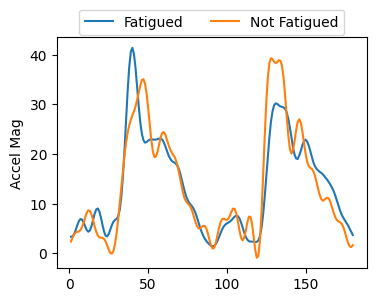

In [4]:
fatigue_df.iloc[4][1:].plot(label='Fatigued')
fatigue_df.iloc[-5][1:].plot(figsize=(4,3), label = 'Not Fatigued')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),ncol=2)
plt.ylabel('Accel Mag')


In [5]:
y = fatigue_df.pop(0).values
X = fatigue_df.values

### Task 1
Calculate the accuracy of a logistic regression classifier (`SGDClassifier`) on the raw time series data for subject A. 

In [6]:
X.shape, y.shape

((421, 180), (421,))

In [7]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of the Logistic Regression classifier on fatigue A: {accuracy:.2f}")

Accuracy of the Logistic Regression classifier on fatigue A: 0.69


### Task 2
The RunningCore Notebook contains code to convert the data to the `sktime` time-series format. Using this format assess the accuracy of the Rocket transformer coupled with an `SGDClassifier` classifier on the data for subject A. 


In [8]:
X3d = X[:,np.newaxis,:] # time series algs require a 3D data array (sample, var, tick)
X3d.shape

(421, 1, 180)

In [9]:
X_train_x3d, X_test_x3d, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

rocket = Rocket()
rocket.fit(X_train_x3d)
X_train_transform = rocket.transform(X_train_x3d)
X_test_transform = rocket.transform(X_test_x3d)

classifier.fit(X_train_transform, y_train)
#accuracy = classifier.score(X_test_transform, y_test)

y_pred = classifier.predict(X_test_transform)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9529411764705882


### Task 3
Use StandardScaler


In [73]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

1. SGDClassifier

In [89]:
classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Accuracy with SGDClassifier: {accuracy_sgd}")

Accuracy with SGDClassifier: 0.8823529411764706


In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.2],
    'penalty': ['l2', 'l1', 'elasticnet']
}

sgd_classifier = SGDClassifier(loss='log_loss', random_state=42)

grid_search = GridSearchCV(sgd_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_scaled)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy with SGDClassifier: {accuracy_sgd}")


Best Hyperparameters: {'alpha': 0.01, 'eta0': 0.2, 'learning_rate': 'adaptive', 'penalty': 'elasticnet'}
Accuracy with SGDClassifier: 0.8823529411764706


In [75]:
from sklearn.ensemble import BaggingClassifier

ensemble_classifier = BaggingClassifier(classifier, n_estimators=10, random_state=42)
ensemble_classifier.fit(X_train_scaled, y_train)

y_pred = ensemble_classifier.predict(X_test_scaled)
accuracy_bag = accuracy_score(y_test, y_pred)
print(f"Accuracy with Bagging Classifier: {accuracy_bag}")

Accuracy with Bagging Classifier: 0.8941176470588236


2. Ramdom Forest Classifier

In [76]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9411764705882353


In [77]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9529411764705882


3. Neural Network

In [80]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Accuracy with Neural Network: {accuracy_nn}")


Epoch 1/10
11/11 [==============================] - 0s 1ms/step - loss: 0.7556 - accuracy: 0.5833
Epoch 2/10
11/11 [==============================] - 0s 3ms/step - loss: 0.5084 - accuracy: 0.7619
Epoch 3/10
11/11 [==============================] - 0s 2ms/step - loss: 0.4086 - accuracy: 0.8125
Epoch 4/10
11/11 [==============================] - 0s 1ms/step - loss: 0.3465 - accuracy: 0.8542
Epoch 5/10
11/11 [==============================] - 0s 1ms/step - loss: 0.3150 - accuracy: 0.8810
Epoch 6/10
11/11 [==============================] - 0s 1ms/step - loss: 0.2694 - accuracy: 0.9167
Epoch 7/10
11/11 [==============================] - 0s 1ms/step - loss: 0.2518 - accuracy: 0.9256
Epoch 8/10
11/11 [==============================] - 0s 2ms/step - loss: 0.2235 - accuracy: 0.9375
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.2042 - accuracy: 0.9464
Epoch 10/10
3/3 [==============================] - 0s 3ms/step
Accuracy with Neural Network: 0.9411764705882353


4. Support Vector Machines

In [81]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=42)  
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy with Support Vector Machine: {accuracy_svm}")

Accuracy with Support Vector Machine: 0.9647058823529412


5. k-Nearest Neighbors 

In [82]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy with k-Nearest Neighbors: {accuracy_knn}")

Accuracy with k-Nearest Neighbors: 0.9294117647058824


In [86]:
results = {
    "SGDClassifier": accuracy_sgd,
    "BaggingClassifier": accuracy_bag,
    "Neural Network": accuracy_nn,
    "SVM": accuracy_svm,
    "Random Forest": accuracy_rf,
    "k-Nearest Neighbors": accuracy_knn,
}

best_model = max(results, key=results.get)
print("\nCombined Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.4f}")


Combined Results:
SGDClassifier: 0.8824
BaggingClassifier: 0.8941
Neural Network: 0.9412
SVM: 0.9647
Random Forest: 0.9529
k-Nearest Neighbors: 0.9294

Best Model: SVM with Accuracy: 0.9647


Conclusion: The SVM (Support Vector Machine) model achieved the highest accuracy (96.47%) among the classifiers tested, making it the best-performing model. Other models, such as the Neural Network, Random Forest, Gradient Boosting, SGDClassifier, BaggingClassifier and k-Nearest Neighbors, also demonstrated good performance, but SVM stood out as the most accurate classifier for the given dataset.

### Task 4
Test the Rocket transformer with different numbers of kernels. 

In [19]:
X_train_x3d, X_test_x3d, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

rocket = Rocket()
rocket.fit(X_train_x3d)
X_train_transform = rocket.transform(X_train_x3d)
X_test_transform = rocket.transform(X_test_x3d)

1. SGDClassifier

In [20]:
classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Accuracy with SGDClassifier: {accuracy_sgd}")

Accuracy with SGDClassifier: 0.788235294117647


In [21]:
from sklearn.ensemble import BaggingClassifier

ensemble_classifier = BaggingClassifier(classifier, n_estimators=10, random_state=42)
ensemble_classifier.fit(X_train_transform, y_train)

y_pred = ensemble_classifier.predict(X_test_transform)
accuracy_bag = accuracy_score(y_test, y_pred)
print(f"Accuracy with Bagging Classifier: {accuracy_bag}")

Accuracy with Bagging Classifier: 0.9529411764705882


2. Ramdom Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9529411764705882


3. Neural Network

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transform.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_transform, y_train, epochs=10, batch_size=32)

y_pred_proba = model.predict(X_test_transform)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Accuracy with Neural Network: {accuracy_nn}")


Epoch 1/10
11/11 [==============================] - 1s 9ms/step - loss: 19.2674 - accuracy: 0.4673
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 9.0953 - accuracy: 0.5327
Epoch 3/10
11/11 [==============================] - 0s 7ms/step - loss: 2.1354 - accuracy: 0.6310
Epoch 4/10
11/11 [==============================] - 0s 6ms/step - loss: 0.8513 - accuracy: 0.7917
Epoch 5/10
11/11 [==============================] - 0s 6ms/step - loss: 0.5577 - accuracy: 0.8423
Epoch 6/10
11/11 [==============================] - 0s 8ms/step - loss: 0.4474 - accuracy: 0.8571
Epoch 7/10
11/11 [==============================] - 0s 5ms/step - loss: 0.3973 - accuracy: 0.8512
Epoch 8/10
11/11 [==============================] - 0s 15ms/step - loss: 0.7890 - accuracy: 0.7589
Epoch 9/10
11/11 [==============================] - 0s 6ms/step - loss: 0.4952 - accuracy: 0.8274
Epoch 10/10
3/3 [==============================] - 0s 2ms/step
Accuracy with Neural Network: 0.9058823529411765


4. Support Vector Machines

In [24]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=42)  
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy with Support Vector Machine: {accuracy_svm}")

Accuracy with Support Vector Machine: 0.8941176470588236


5. Gradient Boosting

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_transform, y_train)

y_pred_gb = gb_classifier.predict(X_test_transform)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy with Gradient Boosting: {accuracy_gb}")

Accuracy with Gradient Boosting: 0.9529411764705882


In [26]:
results = {
    "SGDClassifier": accuracy_sgd,
    "Neural Network": accuracy_nn,
    "SVM": accuracy_svm,
    "Random Forest": accuracy_rf,
    "Gradient Boosting": accuracy_gb,
}

best_model = max(results, key=results.get)
print("\nCombined Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.4f}")


Combined Results:
SGDClassifier: 0.7882
Neural Network: 0.9059
SVM: 0.8941
Random Forest: 0.9529
Gradient Boosting: 0.9529

Best Model: Random Forest with Accuracy: 0.9529


In [28]:
X_train_x3d, X_test_x3d, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

num_kernels_list = [10,30,50,70,90,110]

results = {}

for num_kernels in num_kernels_list:
    rocket = Rocket(num_kernels=num_kernels)
    rocket.fit(X_train_x3d)
    
    X_train_transform = rocket.transform(X_train_x3d)
    X_test_transform = rocket.transform(X_test_x3d)

    classifiers = {
        "SGDClassifier": SGDClassifier(random_state=42),
        "Neural Network": MLPClassifier(random_state=42),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
    }

    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_transform, y_train)
        y_pred = classifier.predict(X_test_transform)
        accuracy = accuracy_score(y_test, y_pred)
        results.setdefault(classifier_name, []).append(accuracy)

for classifier_name, accuracies in results.items():
    print(f"{classifier_name} Accuracies: {accuracies}")


SGDClassifier Accuracies: [0.8117647058823529, 0.7647058823529411, 0.6705882352941176, 0.8941176470588236, 0.6470588235294118, 0.8470588235294118]
Neural Network Accuracies: [0.8235294117647058, 0.8705882352941177, 0.8941176470588236, 0.9647058823529412, 0.8941176470588236, 0.9529411764705882]
SVM Accuracies: [0.8235294117647058, 0.7529411764705882, 0.8470588235294118, 0.8941176470588236, 0.8705882352941177, 0.8941176470588236]
Random Forest Accuracies: [0.9176470588235294, 0.9058823529411765, 0.9176470588235294, 0.9529411764705882, 0.9529411764705882, 0.9411764705882353]


In [30]:
best_accuracies = {}
best_num_kernels = {}

for classifier_name, accuracies in results.items():
    best_accuracy = max(accuracies)
    best_index = accuracies.index(best_accuracy)
    best_num_kernel = num_kernels_list[best_index]

    best_accuracies[classifier_name] = best_accuracy
    best_num_kernels[classifier_name] = best_num_kernel

for classifier_name, best_accuracy in best_accuracies.items():
    best_kernel = best_num_kernels[classifier_name]
    print(f"{classifier_name} - Best Accuracy: {best_accuracy:.4f} with num_kernels={best_kernel}")

SGDClassifier - Best Accuracy: 0.8941 with num_kernels=70
Neural Network - Best Accuracy: 0.9647 with num_kernels=70
SVM - Best Accuracy: 0.8941 with num_kernels=70
Random Forest - Best Accuracy: 0.9529 with num_kernels=70


In summary, the optimal number of kernels across different classifiers consistently appears to be 70. The Neural Network achieved the highest accuracy among all classifiers at 0.9647, closely followed by the Random Forest classifier, which consistently performed well with accuracies above 0.9. The performance of the SGDClassifier and SVM varied more across runs, and their optimal number of kernels was also found to be 70.

### Task5

In [145]:
fatigue_df2 = pd.read_csv('fatigueB.csv', header = None)
fatigue_df2

,0,1,2,3,4,5,6,7,8,9,...,171,172,173,174,175,176,177,178,179,180
0,F,1.49,4.09,9.27,12.70,12.80,12.00,12.40,13.20,13.00,...,9.53,9.30,9.61,9.25,8.07,7.62,8.76,9.61,7.63,3.57
1,F,7.35,7.25,7.80,7.94,7.34,6.48,5.87,5.47,5.20,...,8.92,7.66,7.76,8.28,8.99,10.20,11.60,11.90,10.70,8.72
2,F,9.31,9.06,9.41,9.51,9.23,9.14,9.08,8.45,7.63,...,11.40,10.50,9.63,9.29,9.75,10.20,10.10,10.10,10.20,10.00
3,F,9.82,10.50,9.86,10.20,10.90,10.60,9.97,9.50,8.15,...,11.50,10.60,9.07,7.65,6.83,6.67,6.28,5.09,4.77,7.00
4,F,4.68,3.68,4.63,5.01,4.05,3.40,4.00,4.62,4.25,...,11.90,10.60,11.10,12.90,14.00,13.60,13.00,12.80,11.50,8.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,NF,5.47,5.91,6.08,6.72,8.01,8.76,8.48,8.15,8.23,...,11.00,9.36,9.18,9.72,9.54,8.58,7.64,6.76,5.73,5.18
247,NF,4.79,5.81,6.82,7.60,8.36,9.01,9.19,9.04,8.79,...,13.70,12.90,11.80,9.63,7.22,5.84,5.64,5.63,5.09,4.53
248,NF,4.05,4.92,5.89,6.83,7.89,8.74,8.99,8.86,8.60,...,8.02,7.02,6.58,6.33,5.77,4.99,4.51,4.36,4.11,3.80
249,NF,3.98,4.71,4.72,5.26,6.18,6.55,7.01,7.75,7.50,...,7.68,7.50,6.54,5.74,5.45,5.12,4.64,3.91,2.97,2.90


In [146]:
y = fatigue_df2.pop(0).values
X = fatigue_df2.values

#### Task5-Task3
StandardScaler

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [121]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

1. SGDClassifier

In [122]:
classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Accuracy with SGDClassifier: {accuracy_sgd}")

Accuracy with SGDClassifier: 0.803921568627451


In [123]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 0.2],
    'penalty': ['l2', 'l1', 'elasticnet']
}

sgd_classifier = SGDClassifier(loss='log_loss', random_state=42)

grid_search = GridSearchCV(sgd_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_classifier = grid_search.best_estimator_

y_pred = best_classifier.predict(X_test_scaled)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Accuracy with SGDClassifier: {accuracy_sgd}")


Best Hyperparameters: {'alpha': 0.01, 'eta0': 0.2, 'learning_rate': 'invscaling', 'penalty': 'elasticnet'}
Accuracy with SGDClassifier: 0.8627450980392157


In [124]:
from sklearn.ensemble import BaggingClassifier

ensemble_classifier = BaggingClassifier(classifier, n_estimators=10, random_state=42)
ensemble_classifier.fit(X_train_scaled, y_train)

y_pred = ensemble_classifier.predict(X_test_scaled)
accuracy_bag = accuracy_score(y_test, y_pred)
print(f"Accuracy with Bagging Classifier: {accuracy_bag}")

Accuracy with Bagging Classifier: 0.8627450980392157


2. Ramdom Forest Classifier

In [125]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9019607843137255


In [126]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=2)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9215686274509803


3. Neural Network

In [133]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=10, batch_size=32)

y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Accuracy with Neural Network: {accuracy_nn}")


Epoch 1/10
7/7 [==============================] - 0s 3ms/step - loss: 0.6414 - accuracy: 0.6550
Epoch 2/10
7/7 [==============================] - 0s 2ms/step - loss: 0.4319 - accuracy: 0.8200
Epoch 3/10
7/7 [==============================] - 0s 4ms/step - loss: 0.3605 - accuracy: 0.8400
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 0.2991 - accuracy: 0.8750
Epoch 5/10
7/7 [==============================] - 0s 6ms/step - loss: 0.2482 - accuracy: 0.9150
Epoch 6/10
7/7 [==============================] - 0s 3ms/step - loss: 0.2173 - accuracy: 0.9400
Epoch 7/10
7/7 [==============================] - 0s 5ms/step - loss: 0.1927 - accuracy: 0.9450
Epoch 8/10
7/7 [==============================] - 0s 3ms/step - loss: 0.1662 - accuracy: 0.9650
Epoch 9/10
7/7 [==============================] - 0s 2ms/step - loss: 0.1485 - accuracy: 0.9800
Epoch 10/10
2/2 [==============================] - 0s 3ms/step
Accuracy with Neural Network: 0.8823529411764706


4. Support Vector Machines

In [140]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=42)  
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy with Support Vector Machine: {accuracy_svm}")

Accuracy with Support Vector Machine: 0.9019607843137255


5. k-Nearest Neighbors 

In [141]:
from sklearn.neighbors import KNeighborsClassifier

for n_neighbors in [3, 5, 7, 9]:
    knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_classifier.fit(X_train_scaled, y_train)
    y_pred = knn_classifier.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy with {n_neighbors} neighbors: {accuracy}")

Accuracy with 3 neighbors: 0.9019607843137255
Accuracy with 5 neighbors: 0.803921568627451
Accuracy with 7 neighbors: 0.803921568627451
Accuracy with 9 neighbors: 0.7843137254901961


In [142]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train_scaled, y_train)

y_pred = classifier.predict(X_test_scaled)
accuracy_knn = accuracy_score(y_test, y_pred)
print(f"Accuracy with k-Nearest Neighbors: {accuracy_knn}")

Accuracy with k-Nearest Neighbors: 0.9019607843137255


In [143]:
results = {
    "SGDClassifier": accuracy_sgd,
    "BaggingClassifier": accuracy_bag,
    "Neural Network": accuracy_nn,
    "SVM": accuracy_svm,
    "Random Forest": accuracy_rf,
    "k-Nearest Neighbors": accuracy_knn,
}

best_model = max(results, key=results.get)
print("\nCombined Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.4f}")


Combined Results:
SGDClassifier: 0.8627
BaggingClassifier: 0.8627
Neural Network: 0.8824
SVM: 0.9020
Random Forest: 0.9216
k-Nearest Neighbors: 0.9020

Best Model: Random Forest with Accuracy: 0.9216


Random Forest with Accuracy: 0.9216

The Random Forest model emerged as the best-performing classifier, outperforming the others with the highest accuracy of 0.9216.
In summary, the Random Forest model stands out as the most effective classifier for this dataset, providing the highest accuracy among the models evaluated. It's important to note that the choice of the best model may depend on the specific characteristics of the data and the goals of the analysis.

Previous result with fatigueB:

Combined Results:
- SGDClassifier: 0.8824
- BaggingClassifier: 0.8941
- Neural Network: 0.9412
- SVM: 0.9647
- Random Forest: 0.9529
- k-Nearest Neighbors: 0.9294

Best Model: SVM with Accuracy: 0.9647

#### Task5-Task4
Test the Rocket transformer with different numbers of kernels. 

In [153]:
X3d = X[:,np.newaxis,:] 
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
X_train_x3d, X_test_x3d, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

rocket = Rocket()
rocket.fit(X_train_x3d)
X_train_transform = rocket.transform(X_train_x3d)
X_test_transform = rocket.transform(X_test_x3d)

1. SGDClassifier

In [154]:
classifier = SGDClassifier(loss='log_loss', random_state=42)
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_sgd = accuracy_score(y_test, y_pred)

print(f"Accuracy with SGDClassifier: {accuracy_sgd}")

Accuracy with SGDClassifier: 0.8823529411764706


In [155]:
from sklearn.ensemble import BaggingClassifier

ensemble_classifier = BaggingClassifier(classifier, n_estimators=10, random_state=42)
ensemble_classifier.fit(X_train_transform, y_train)

y_pred = ensemble_classifier.predict(X_test_transform)
accuracy_bag = accuracy_score(y_test, y_pred)
print(f"Accuracy with Bagging Classifier: {accuracy_bag}")

Accuracy with Bagging Classifier: 0.8627450980392157


2. Ramdom Forest Classifier

In [156]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_rf = accuracy_score(y_test, y_pred)

print(f"Accuracy with Random Forest: {accuracy_rf}")

Accuracy with Random Forest: 0.9215686274509803


3. Neural Network

In [158]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_transform.shape[1],)),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_transform, y_train, epochs=10, batch_size=32)

y_pred_proba = model.predict(X_test_transform)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Accuracy with Neural Network: {accuracy_nn}")


Epoch 1/10
7/7 [==============================] - 0s 7ms/step - loss: 13.6565 - accuracy: 0.5500
Epoch 2/10
7/7 [==============================] - 0s 14ms/step - loss: 0.6885 - accuracy: 0.4850
Epoch 3/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 4/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 5/10
7/7 [==============================] - 0s 11ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 6/10
7/7 [==============================] - 0s 10ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 7/10
7/7 [==============================] - 0s 8ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 8/10
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 9/10
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5000
Epoch 10/10
2/2 [==============================] - 0s 2ms/step
Accuracy with Neural Network: 0.4117647058823529


In [159]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_transform.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_transform, y_train, epochs=10, batch_size=64)
y_pred_proba = model.predict(X_test_transform)
y_pred = (y_pred_proba > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred)
print(f"Accuracy with Neural Network: {accuracy_nn}")

Epoch 1/10
4/4 [==============================] - 1s 10ms/step - loss: 6.4481 - accuracy: 0.4700
Epoch 2/10
4/4 [==============================] - 0s 11ms/step - loss: 2.2432 - accuracy: 0.5300
Epoch 3/10
4/4 [==============================] - 0s 9ms/step - loss: 2.2138 - accuracy: 0.5950
Epoch 4/10
4/4 [==============================] - 0s 14ms/step - loss: 1.8003 - accuracy: 0.5800
Epoch 5/10
4/4 [==============================] - 0s 21ms/step - loss: 1.0023 - accuracy: 0.6350
Epoch 6/10
4/4 [==============================] - 0s 10ms/step - loss: 0.5982 - accuracy: 0.7650
Epoch 7/10
4/4 [==============================] - 0s 11ms/step - loss: 0.4036 - accuracy: 0.8200
Epoch 8/10
4/4 [==============================] - 0s 10ms/step - loss: 0.2861 - accuracy: 0.8900
Epoch 9/10
4/4 [==============================] - 0s 22ms/step - loss: 0.2582 - accuracy: 0.9100
Epoch 10/10
2/2 [==============================] - 0s 8ms/step
Accuracy with Neural Network: 0.8235294117647058


4. Support Vector Machines

In [160]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', random_state=42)  
classifier.fit(X_train_transform, y_train)

y_pred = classifier.predict(X_test_transform)
accuracy_svm = accuracy_score(y_test, y_pred)
print(f"Accuracy with Support Vector Machine: {accuracy_svm}")

Accuracy with Support Vector Machine: 0.803921568627451


In [161]:
from sklearn.model_selection import GridSearchCV

param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': ['scale', 'auto']}
grid_search_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=5)
grid_search_svm.fit(X_train_transform, y_train)

best_svm_classifier = grid_search_svm.best_estimator_

y_pred_svm = best_svm_classifier.predict(X_test_transform)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"Best Accuracy with Support Vector Machine: {accuracy_svm}")


Best Accuracy with Support Vector Machine: 0.9607843137254902


5. Gradient Boosting

In [162]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train_transform, y_train)

y_pred_gb = gb_classifier.predict(X_test_transform)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy with Gradient Boosting: {accuracy_gb}")

Accuracy with Gradient Boosting: 0.803921568627451


In [163]:
results = {
    "SGDClassifier": accuracy_sgd,
    "Neural Network": accuracy_nn,
    "SVM": accuracy_svm,
    "Random Forest": accuracy_rf,
    "Gradient Boosting": accuracy_gb,
}

best_model = max(results, key=results.get)
print("\nCombined Results:")
for model, accuracy in results.items():
    print(f"{model}: {accuracy:.4f}")
print(f"\nBest Model: {best_model} with Accuracy: {results[best_model]:.4f}")


Combined Results:
SGDClassifier: 0.8824
Neural Network: 0.8235
SVM: 0.9608
Random Forest: 0.9216
Gradient Boosting: 0.8039

Best Model: SVM with Accuracy: 0.9608


In [164]:
X_train_x3d, X_test_x3d, y_train, y_test = train_test_split(X3d, y, test_size=0.2, random_state=42)

num_kernels_list = [10,30,50,70,90,110]

results = {}

for num_kernels in num_kernels_list:
    rocket = Rocket(num_kernels=num_kernels)
    rocket.fit(X_train_x3d)
    
    X_train_transform = rocket.transform(X_train_x3d)
    X_test_transform = rocket.transform(X_test_x3d)

    classifiers = {
        "SGDClassifier": SGDClassifier(random_state=42),
        "Neural Network": MLPClassifier(random_state=42),
        "SVM": SVC(kernel='rbf', random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
    }

    for classifier_name, classifier in classifiers.items():
        classifier.fit(X_train_transform, y_train)
        y_pred = classifier.predict(X_test_transform)
        accuracy = accuracy_score(y_test, y_pred)
        results.setdefault(classifier_name, []).append(accuracy)

for classifier_name, accuracies in results.items():
    print(f"{classifier_name} Accuracies: {accuracies}")


SGDClassifier Accuracies: [0.49019607843137253, 0.9411764705882353, 0.7647058823529411, 0.9215686274509803, 0.7450980392156863, 0.7450980392156863]
Neural Network Accuracies: [0.7843137254901961, 0.9215686274509803, 0.8431372549019608, 0.8235294117647058, 0.8431372549019608, 0.8235294117647058]
SVM Accuracies: [0.7450980392156863, 0.8823529411764706, 0.8235294117647058, 0.803921568627451, 0.7647058823529411, 0.803921568627451]
Random Forest Accuracies: [0.8823529411764706, 0.9411764705882353, 0.8823529411764706, 0.9019607843137255, 0.8823529411764706, 0.9215686274509803]


In [165]:
best_accuracies = {}
best_num_kernels = {}

for classifier_name, accuracies in results.items():
    best_accuracy = max(accuracies)
    best_index = accuracies.index(best_accuracy)
    best_num_kernel = num_kernels_list[best_index]

    best_accuracies[classifier_name] = best_accuracy
    best_num_kernels[classifier_name] = best_num_kernel

for classifier_name, best_accuracy in best_accuracies.items():
    best_kernel = best_num_kernels[classifier_name]
    print(f"{classifier_name} - Best Accuracy: {best_accuracy:.4f} with num_kernels={best_kernel}")

SGDClassifier - Best Accuracy: 0.9412 with num_kernels=30
Neural Network - Best Accuracy: 0.9216 with num_kernels=30
SVM - Best Accuracy: 0.8824 with num_kernels=30
Random Forest - Best Accuracy: 0.9412 with num_kernels=30


previous result:

- SGDClassifier - Best Accuracy: 0.8941 with num_kernels=70
- Neural Network - Best Accuracy: 0.9647 with num_kernels=70
- SVM - Best Accuracy: 0.8941 with num_kernels=70
- Random Forest - Best Accuracy: 0.9529 with num_kernels=70

Conclusion:

- The optimal number of kernels varied between the two datasets, suggesting that the characteristics of the datasets impact the choice of this hyperparameter.
- The Neural Network showed higher accuracy on fatigueA.csv, while the SGDClassifier performed better on fatigueB.csv.
- SVM and Random Forest had comparable performance on both datasets, with minor variations in accuracy.